In [1]:
%load_ext autoreload
%autoreload 2
import pickle as pkl
import warnings

import embgam
import matplotlib.pyplot as plt
import numpy as np
import torch
import transformers
from embgam import data
from sklearn.base import ClassifierMixin, RegressorMixin

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import dvu
dvu.set_style()
sys.path.append('../results')
pd.set_option('display.max_rows', None)

In [2]:
def sparse_predict(model, X, warn, frac_ngrams=1):
    """Predict only the cached coefs in self.coefs_dict_"""
    assert hasattr(model, "coefs_dict_"), "coefs are not cached!"
    preds = []
    n_unseen_ngrams = 0
    for x in X:
        pred_list = []
        seqs = embgam.embed.generate_ngrams_list(
            x,
            ngrams=model.ngrams,
            tokenizer_ngrams=model.tokenizer_ngrams,
            all_ngrams=model.all_ngrams,
        )

        for seq in seqs:
            if seq in model.coefs_dict_:
                pred_list.append(model.coefs_dict_[seq])
            else:
                n_unseen_ngrams += 1

        def key(x):
            if type(x) is np.ndarray:
                return sum(abs(x))
            return abs(x)

        pred_arr = np.array(sorted(pred_list, key=key, reverse=True))

        if len(pred_arr) == 0:
            preds.append(0)
        elif frac_ngrams < 1:
            # only look at a fraction of seqs
            if pred_arr.ndim == 1:
                cumsum = np.cumsum(np.abs(pred_arr))
            elif pred_arr.ndim == 2:
                cumsum = np.cumsum(np.sum(np.abs(pred_arr), axis=1))

            # note cumsum[-1] is the total sum of absolute value of all the elements
            idx = np.where((cumsum / cumsum[-1]) > frac_ngrams)[0][0]
            preds.append(sum(pred_arr[: idx + 1]))
        else:
            preds.append(sum(pred_arr))

    if n_unseen_ngrams > 0 and warn:
        warnings.warn(
            f"Saw an unseen ungram {n_unseen_ngrams} times. \
For better performance, call cache_linear_coefs on the test dataset \
before calling predict."
        )

    preds = np.array(preds)
    if isinstance(model, RegressorMixin):
        return preds
    elif isinstance(model, ClassifierMixin):
        if preds.ndim > 1:
            return np.argmax(preds, axis=1)
        return ((preds + model.linear.intercept_) > 0).astype(int)

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
dsets = {
    "financial_phrasebank": "ahmedrachid/FinancialBERT-Sentiment-Analysis",  # 3 class classification
    "sst2": "textattack/bert-base-uncased-SST-2",
    "emotion": "nateraw/bert-base-uncased-emotion",  # 6 class classification
    "rotten_tomatoes": "textattack/bert-base-uncased-rotten_tomatoes",
}
DSETS_RENAME_DICT = {
    'emotion': 'Emotion',
    'sst2': 'SST2',
    'tweet_eval': 'Tweet (Hate)',
    'rotten_tomatoes': 'Rotten tomatoes',
    'financial_phrasebank': 'Financial phrasebank',
}

In [4]:
acc_vals = {}
frac_ngrams = np.linspace(1, 100, num=100) / 100

for dataset in dsets.keys():
    checkpoint = dsets[dataset]

    # set up data
    dset, dataset_key_text = data.process_data_and_args(dataset)
    dset_train = dset["train"]
    dset_val = dset["validation"]

    # load model
    with open(f"../results/4gram_{dataset}_imodelsx.pkl", "rb") as f:
        m = pkl.load(f)

    # predict
    m.cache_linear_coefs(dset_val[dataset_key_text])

    transformer_model = transformers.AutoModel.from_pretrained(m.checkpoint).to(
        DEVICE
    )
    tokenizer_embeddings = transformers.AutoTokenizer.from_pretrained(m.checkpoint)

    # generate plot
    dataset_acc = []
    for frac in frac_ngrams:
        preds = sparse_predict(
            m, dset_val[dataset_key_text], True, frac_ngrams=frac
        )
        dataset_acc.append(np.mean(preds == dset_val["label"]))

    acc_vals[dataset] = dataset_acc

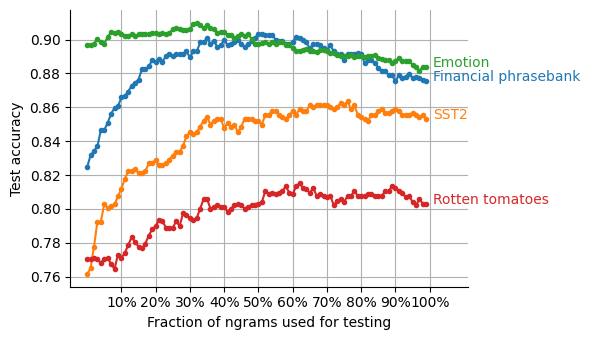

In [ ]:
plt.figure(figsize=(6, 3.5))
for i, dset in enumerate(dsets):
    plt.plot(acc_vals[dset], '.-', label=DSETS_RENAME_DICT[dset])
plt.grid()
plt.xticks(list(range(10,110,10)), [f'{n + 1}0%' for n in range(10)])
plt.ylabel('Test accuracy')
plt.xlabel('Fraction of ngrams used for testing')
dvu.line_legend(fontsize='medium')
plt.tight_layout()
plt.savefig('vary_sparsity.pdf', bbox_inches='tight')
plt.show()